In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import spacy
from spacy.training import Example
from spacy.tokens import DocBin
import re

In [27]:
import pandas as pd

# Ruta al archivo CSV
archivo_csv = 'promocionesCompleto.csv'

# Leer el archivo CSV usando pandas
df = pd.read_csv(archivo_csv)

In [28]:
#Tratamientos nulls

# Contar valores NaN en cada columna
na_counts = df.isna().sum()

# Mostrar el conteo de valores NaN
print(na_counts)

EAN NUEVO      21
DESCRIPCIÓN    19
Descuento      26
Mes             0
Categoria      19
dtype: int64


In [29]:
print(df.columns)
df.columns = df.columns.str.strip()
df = df.rename(columns={'Descuento ': 'Descuento'})

Index(['EAN NUEVO', 'DESCRIPCIÓN', 'Descuento ', 'Mes', 'Categoria'], dtype='object')


In [30]:
#Reemplazo los NAs por el valor de la fila de arriba asumiendo que tiene el mismo valor

df['Descuento'] = df['Descuento'].fillna(method='ffill')

In [31]:
#Borro los EAN que tienen el "TODOS"

df = df[df['EAN NUEVO'] != 'TODOS']
df = df[df['EAN NUEVO'] != 'TODAS']

In [32]:
# Contar cuántas veces aparece cada combinación de 'EAN NUEVO' y 'Mes'
conteo_duplicados = df.groupby(['EAN NUEVO', 'Mes']).size()

# Filtrar las combinaciones que aparecen más de una vez
duplicados_count = conteo_duplicados[conteo_duplicados > 1]

# Mostrar el número de duplicados y las combinaciones duplicadas
print(f"Cantidad de combinaciones duplicadas: {len(duplicados_count)}")
print("Combinaciones duplicadas y su frecuencia:")
print(duplicados_count)

Cantidad de combinaciones duplicadas: 154
Combinaciones duplicadas y su frecuencia:
EAN NUEVO      Mes       
3600524057336  junio         2
4006000005478  julio         2
4006000005515  julio         2
650240068676   julio         2
7506306252868  septiembre    2
                            ..
7899706181877  junio         3
7899706188340  junio         3
79400052919    septiembre    2
79400052926    septiembre    2
8411300692000  junio         2
Length: 154, dtype: int64


In [33]:
#Contar cantidd de duplicados

# Contar la cantidad de duplicados basados en las columnas 'EAN NUEVO' y 'mes'
duplicados = df[df.duplicated(subset=['EAN NUEVO', 'Mes'], keep=False)]

# Mostrar el número de duplicados
print(f"Cantidad de filas duplicadas: {len(duplicados)}")

# Ver las combinaciones duplicadas
print(duplicados[['EAN NUEVO', 'Mes']].drop_duplicates())

Cantidad de filas duplicadas: 350
          EAN NUEVO         Mes
101   7793742007934      agosto
140   7793970136215      agosto
142   7793970136222      agosto
144   7793970136239      agosto
146   7793970136246      agosto
...             ...         ...
2753  7891150034075  septiembre
2760  7506306252868  septiembre
2773    79400052919  septiembre
2775    79400052926  septiembre
2791       78944794  septiembre

[155 rows x 2 columns]


In [34]:
#Elimino duplicados. Un duplicado es aquel que tiene el mismo código y el mismo mes. Se queda el primero
df = df.drop_duplicates(subset=['EAN NUEVO', 'Mes'], keep='first')

In [35]:
#Asegurarse de que los productos que tienen el mismo EAN se llamen igual

# Crear un diccionario para almacenar la primera descripción para cada EAN NUEVO
descripcion_correcta = df.groupby('EAN NUEVO')['DESCRIPCIÓN'].first().to_dict()

# Actualizar el DataFrame con las descripciones correctas
df['DESCRIPCIÓN'] = df['EAN NUEVO'].map(descripcion_correcta)

In [46]:
df['Descuento'].unique()

array([30, 35, 80, 25, 15, 20, 40, 10, 50, 33, 18,  3, 21, 52,  8])

In [47]:
# Función para redondear los valores al múltiplo de 5 más cercano
def redondear_a_5_mas_cercano(valor):
    return 5 * round(valor / 5)

In [50]:
# Función para limpiar y estandarizar los valores de la columna 'Descuento'
def limpiar_descuento(descuento):
    # Convierte el valor a cadena si no lo es
    if isinstance(descuento, str):
        # Convierte a minúsculas y elimina espacios
        descuento = descuento.lower().strip()
        
        # Reemplaza '2x1' y similares por su equivalente en porcentaje sin redondear
        if '2x1' in descuento or '2 x 1' in descuento:
            return 50
        elif '3x2' in descuento:
            return 33  # No redondeamos en este caso
        elif '2do al 80%' in descuento or '2da al 80%' in descuento:
            return 80
        elif '2da al 50%' in descuento:
            return 50
        
        # Elimina el texto 'dto', 'al', y otros irrelevantes
        descuento = re.sub(r'[^0-9,\.%]', '', descuento)
        
        # Reemplaza las comas por puntos (por si hay decimales como 15,00%)
        descuento = descuento.replace(',', '.')
        
        # Si tiene el símbolo %, lo convertimos a número
        if '%' in descuento:
            try:
                # Elimina el símbolo '%' y convierte a float
                valor = round(float(descuento.replace('%', '')))
                # Redondear al múltiplo de 5 más cercano (excepto si es 33)
                return redondear_a_5_mas_cercano(valor) if valor != 33 else 33
            except ValueError:
                return None  # Si hay algún valor inválido, devuelve None
    
    # Si el valor ya es un número, lo devuelve directamente
    if isinstance(descuento, (int, float)):
        return redondear_a_5_mas_cercano(descuento)  # Aplica redondeo

    return None

In [51]:
# Aplicar la función al df
df['Descuento Limpio'] = df['Descuento'].apply(limpiar_descuento)

In [52]:
def reemplazar_ceros_en_df(df, col):
    for i in range(1, len(df)):
        if df.iloc[i][col] == 0:  # Si el valor es 0, reemplaza con el anterior
            df.iloc[i, df.columns.get_loc(col)] = df.iloc[i - 1][col]

In [53]:
# Verifica si el índice es continuo; si no, resetea el índice
df = df.reset_index(drop=True)

In [54]:
# Reemplazar los ceros en la columna 'Descuento Limpio'
reemplazar_ceros_en_df(df, 'Descuento Limpio')

In [55]:
# Si quieres que 'Descuento Limpio' reemplace directamente la columna original:
df['Descuento'] = df['Descuento Limpio']
df.drop(columns='Descuento Limpio', inplace=True)  # Elimina la columna temporal

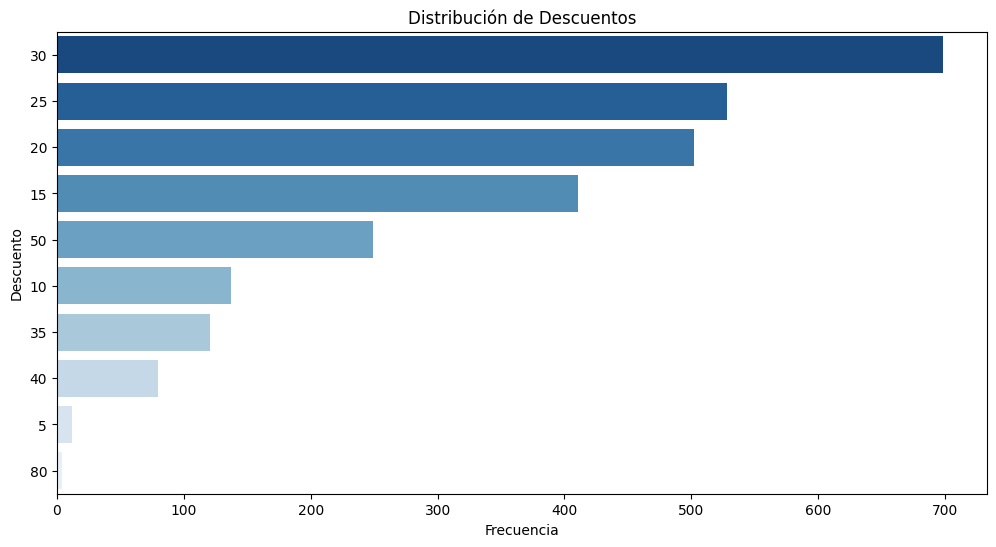

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el número de categorías únicas
num_categories = df['Descuento'].nunique()

# Crear una paleta de colores azul con suficientes tonos distintos
palette = sns.color_palette("Blues", n_colors=num_categories)

# Obtener el orden de las categorías basado en la frecuencia
order = df['Descuento'].value_counts().index

# Invertir la paleta de colores para que el color más oscuro sea para la frecuencia más alta
palette = palette[::-1]

# Crear un diccionario que asigna un color a cada categoría
category_colors = dict(zip(order, palette))

# Gráfico de barras de valores únicos
plt.figure(figsize=(12, 6))
sns.countplot(y='Descuento', data=df, order=order, palette=category_colors)
plt.title('Distribución de Descuentos')
plt.xlabel('Frecuencia')
plt.ylabel('Descuento')
plt.show()


In [57]:
# Función para normalizar texto: convertir a minúsculas y eliminar tildes
def normalizar_texto(texto):
    texto = texto.lower()  # Convertir a minúsculas
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')  # Eliminar tildes
    texto = texto.strip()  # Eliminar espacios adicionales
    return texto

In [58]:
df['Categoria'] = df['Categoria'].apply(normalizar_texto)


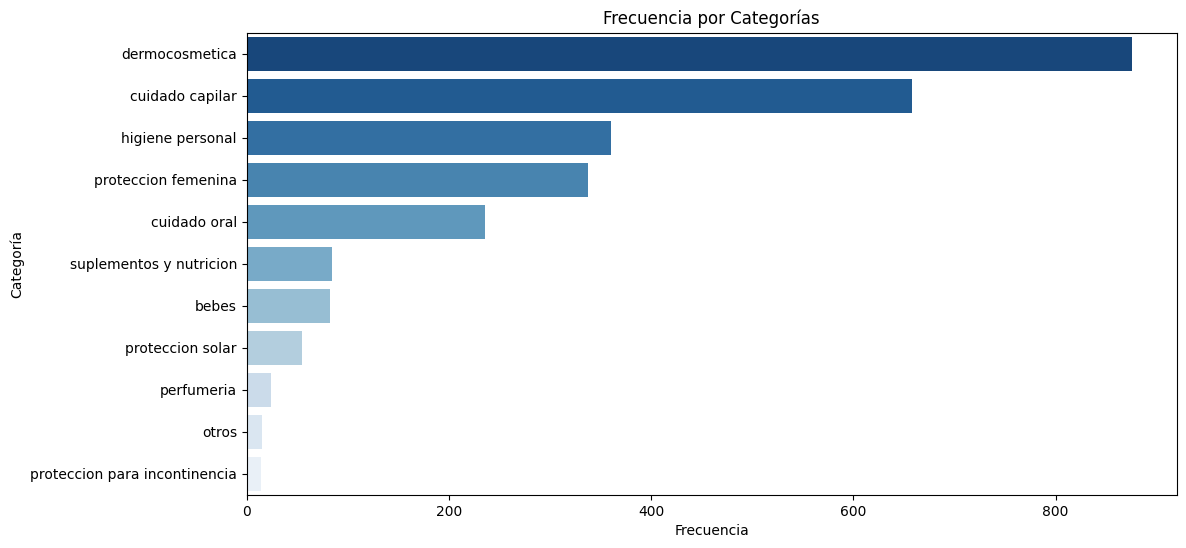

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el número de categorías únicas
num_categories = df['Categoria'].nunique()

# Crear una paleta de colores azul con suficientes tonos distintos
palette = sns.color_palette("Blues", n_colors=num_categories)

# Obtener el orden de las categorías basado en la frecuencia
order = df['Categoria'].value_counts().index

# Invertir la paleta de colores para que el color más oscuro sea para la frecuencia más alta
palette = palette[::-1]

# Crear un diccionario que asigna un color a cada categoría
category_colors = dict(zip(order, palette))

# Gráfico de barras de valores únicos
plt.figure(figsize=(12, 6))
sns.countplot(y='Categoria', data=df, order=order, palette=category_colors)
plt.title('Frecuencia por Categorías')
plt.xlabel('Frecuencia')
plt.ylabel('Categoría')
plt.show()


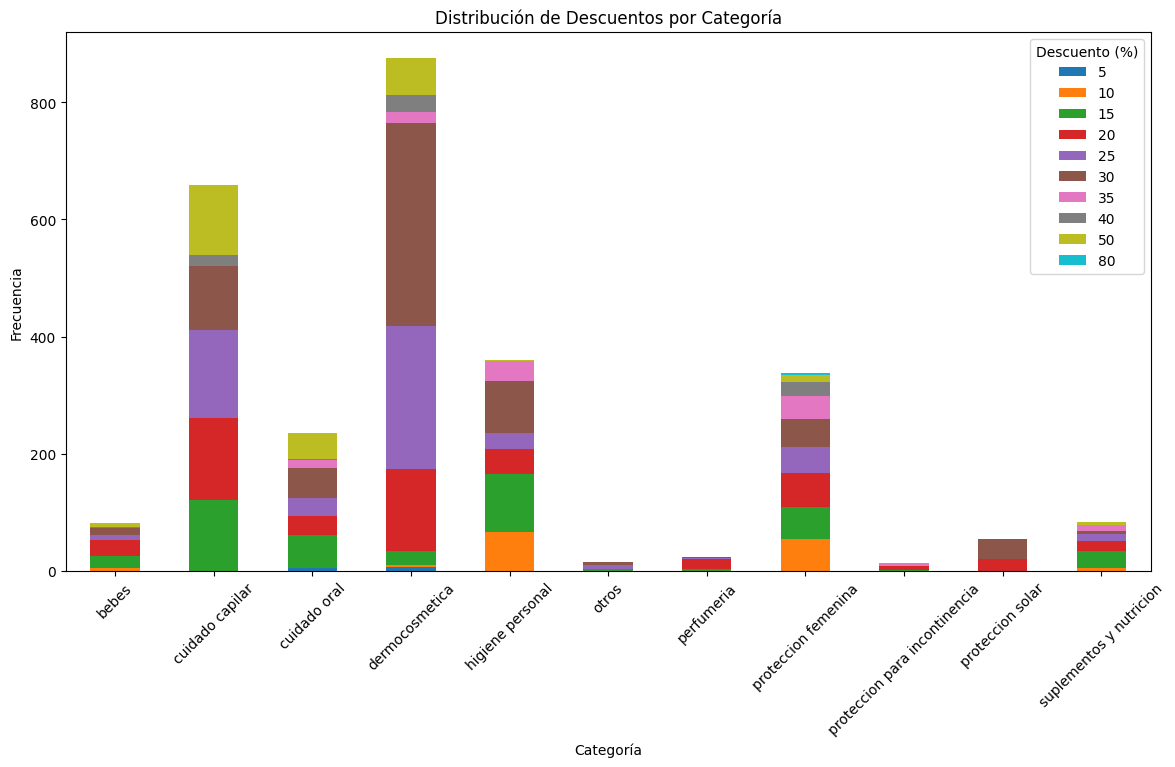

In [59]:
# Contar la frecuencia de cada descuento por categoría
frecuencia_descuentos_categoria = df.groupby('Categoria')['Descuento'].value_counts().unstack().fillna(0)

# Crear un gráfico de barras para visualizar la frecuencia de descuentos por categoría
frecuencia_descuentos_categoria.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Distribución de Descuentos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Descuento (%)')
plt.show()

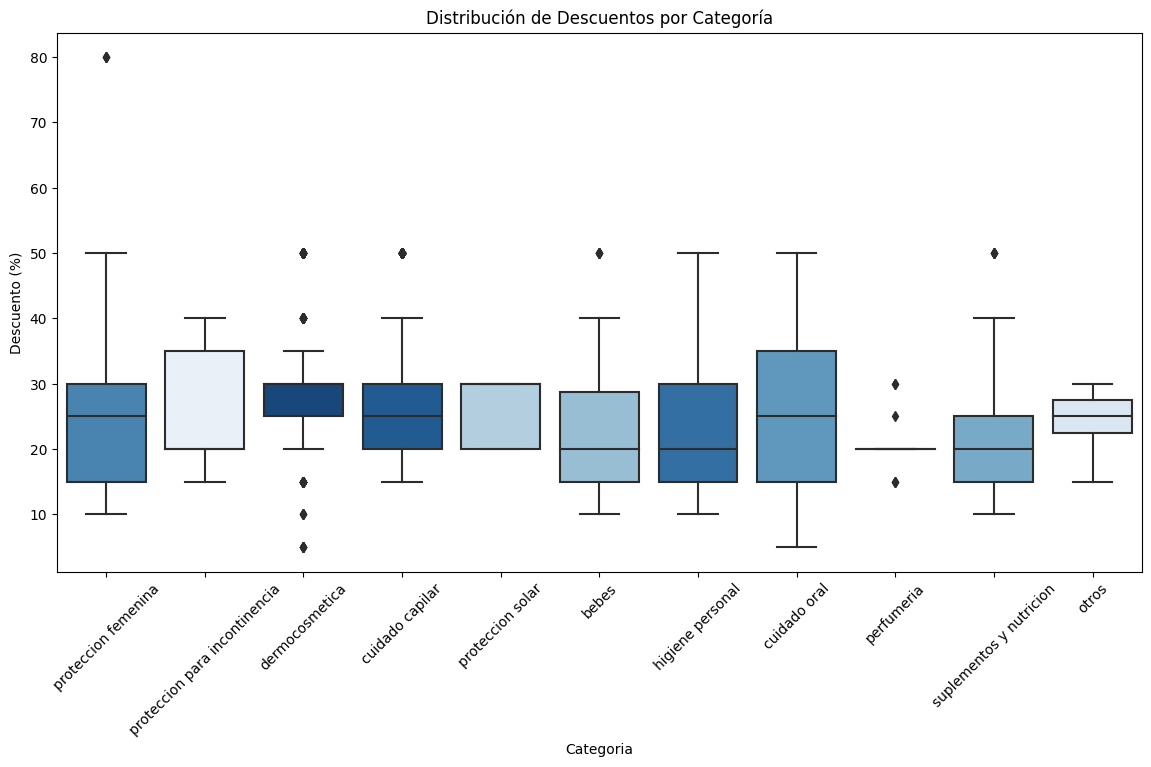

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el número de categorías únicas
num_categories = df['Categoria'].nunique()

# Crear una paleta de colores azul con suficientes tonos distintos
palette = sns.color_palette("Blues", n_colors=num_categories)

# Obtener el orden de las categorías basado en la frecuencia
order = df['Categoria'].value_counts().index

# Invertir la paleta de colores para que el color más oscuro sea para la frecuencia más alta
palette = palette[::-1]

# Crear un diccionario que asigna un color a cada categoría
category_colors = dict(zip(order, palette))

# Crear un gráfico de cajas para visualizar la distribución de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.boxplot(x='Categoria', y='Descuento', data=df, palette=category_colors)
plt.title('Distribución de Descuentos por Categoría')
plt.xlabel('Categoria')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.show()


In [102]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Realizar el ANOVA
anova_model = sm.formula.ols('Descuento ~ Categoria', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

# Mostrar resultados del ANOVA
print(anova_table)


                  sum_sq      df          F        PR(>F)
Categoria   18839.791016    10.0  18.282832  8.818401e-33
Residual   281419.581704  2731.0        NaN           NaN


                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
            group1                        group2            meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------
                        bebes               cuidado capilar   5.0447 0.0011    1.215  8.8743   True
                        bebes                  cuidado oral   5.1612 0.0036   0.9693  9.3531   True
                        bebes                dermocosmetica   5.3915 0.0002    1.615  9.1679   True
                        bebes              higiene personal  -1.6104 0.9696  -5.6119   2.391  False
                        bebes                         otros   1.1951    1.0  -7.9881 10.3783  False
                        bebes                    perfumeria  -2.3882 0.9953  -9.9775  5.2011  False
                        bebes           proteccion femenina   1.7217 0.9538  -2.3038  5.7473  False


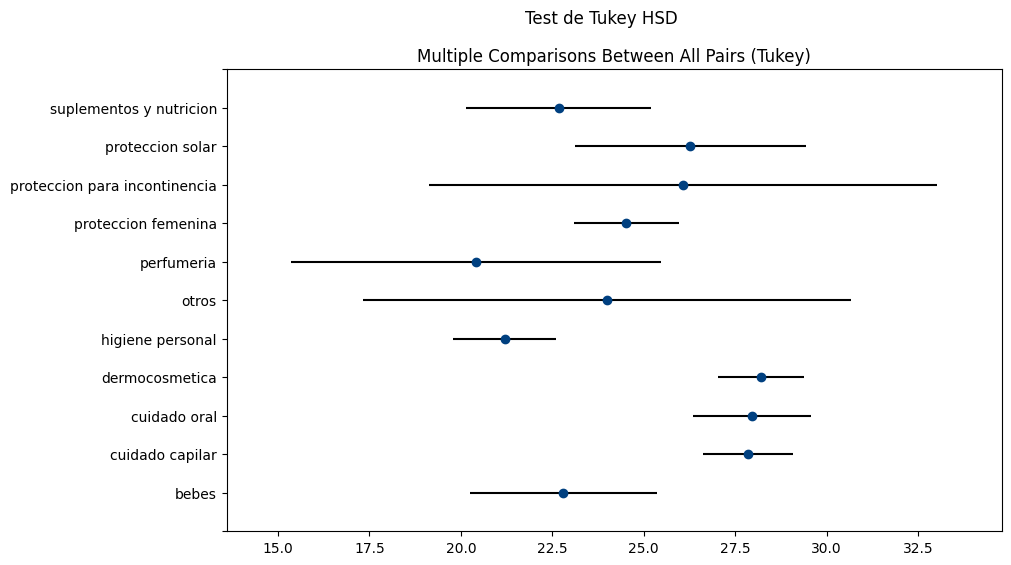

In [119]:
# Realizar el Test de Tukey
tukey = pairwise_tukeyhsd(df['Descuento'], df['Categoria'])
print(tukey)

# Graficar los resultados del Test de Tukey
fig = tukey.plot_simultaneous()

# Obtener el eje actual
ax = plt.gca()

# Obtener la lista de las barras (representan los intervalos de confianza)
for bar in ax.patches:
    bar.set_edgecolor('#004080')  # Color del borde de las barras
    
# Ajustar el color de las líneas
for line in ax.lines:
    line.set_color('#004080')  # Color de las líneas
    
# Cambiar el color de los intervalos (barras horizontales)
colors = sns.color_palette("Blues", n_colors=len(df['Categoria'].unique()))[::-1]  # Paleta de colores invertida
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(colors[i % len(colors)])  # Asignar color de la paleta a cada barra

plt.suptitle('Test de Tukey HSD')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


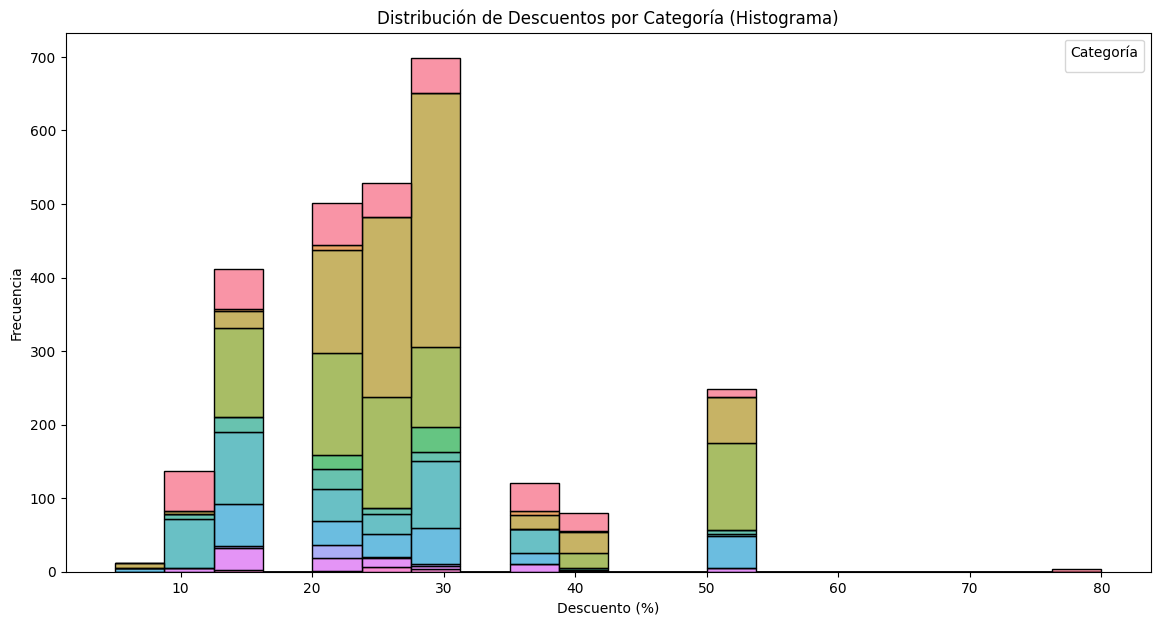

In [64]:
# Crear un histograma de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.histplot(data=df, x='Descuento', hue='Categoria', multiple='stack', bins=20)
plt.title('Distribución de Descuentos por Categoría (Histograma)')
plt.xlabel('Descuento (%)')
plt.ylabel('Frecuencia')
plt.legend(title='Categoría')
plt.show()

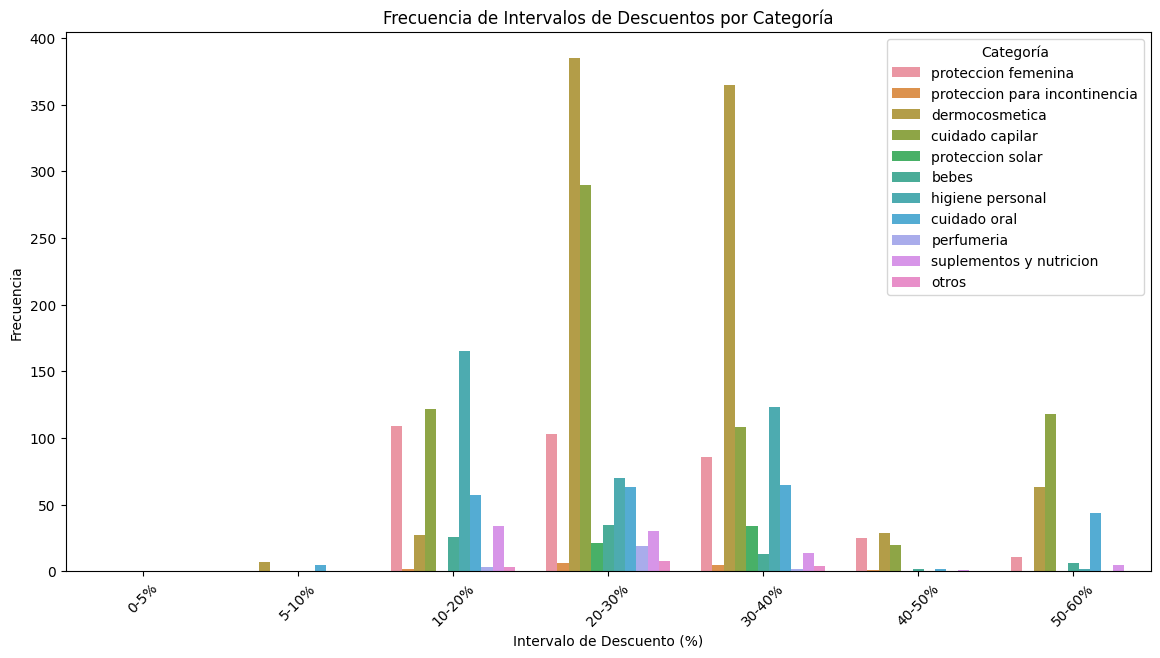

In [65]:
# Definir intervalos de descuento
bins = [0, 5, 10, 20, 30, 40, 50, 60]
labels = ['0-5%', '5-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%']
df['descuentos_binned'] = pd.cut(df['Descuento'], bins=bins, labels=labels, right=False)

# Crear un gráfico de barras para intervalos de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.countplot(data=df, x='descuentos_binned', hue='Categoria')
plt.title('Frecuencia de Intervalos de Descuentos por Categoría')
plt.xlabel('Intervalo de Descuento (%)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


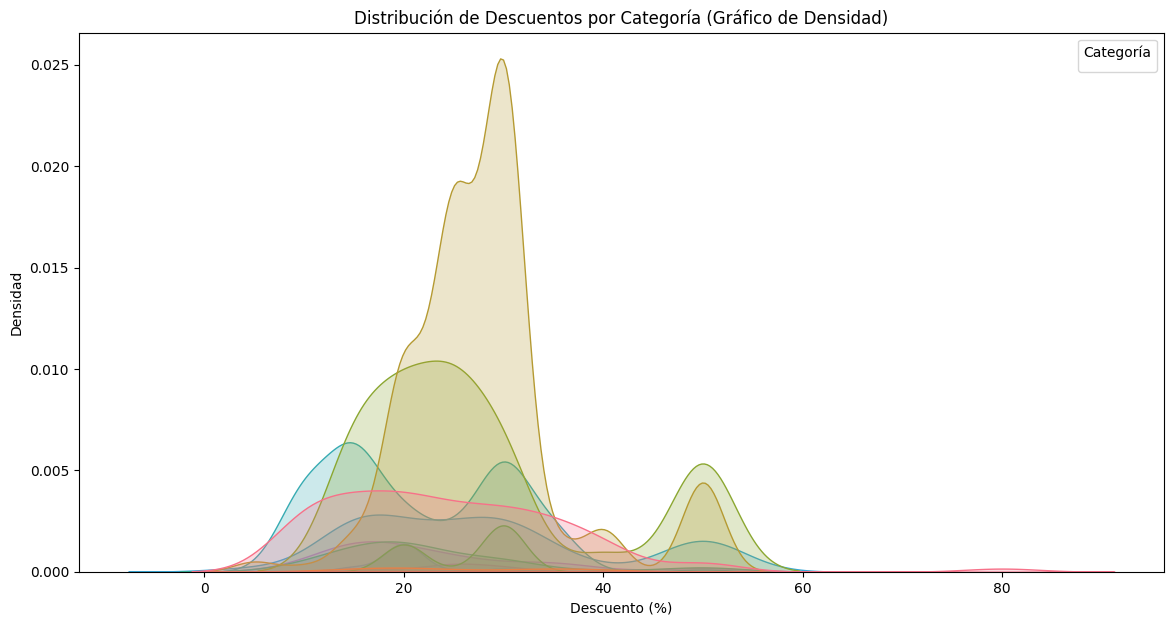

In [66]:
# Crear un gráfico de densidad para visualizar la distribución de descuentos por categoría
plt.figure(figsize=(14, 7))
sns.kdeplot(data=df, x='Descuento', hue='Categoria', fill=True)
plt.title('Distribución de Descuentos por Categoría (Gráfico de Densidad)')
plt.xlabel('Descuento (%)')
plt.ylabel('Densidad')
plt.legend(title='Categoría')
plt.show()

In [67]:
df['Mes'] = df['Mes'].apply(normalizar_texto)

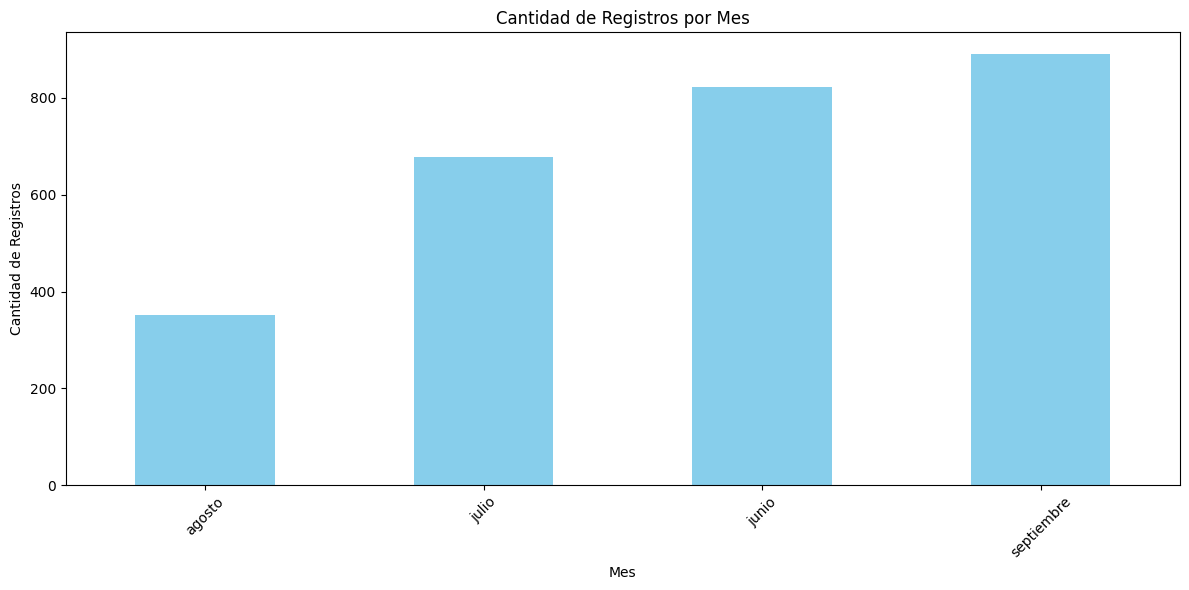

In [68]:
# Contar la cantidad de registros por mes
registros_por_mes = df['Mes'].value_counts().sort_index()

# Crear un gráfico de barras para visualizar la cantidad de registros por mes
plt.figure(figsize=(12, 6))
registros_por_mes.plot(kind='bar', color='skyblue')
plt.title('Cantidad de Registros por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

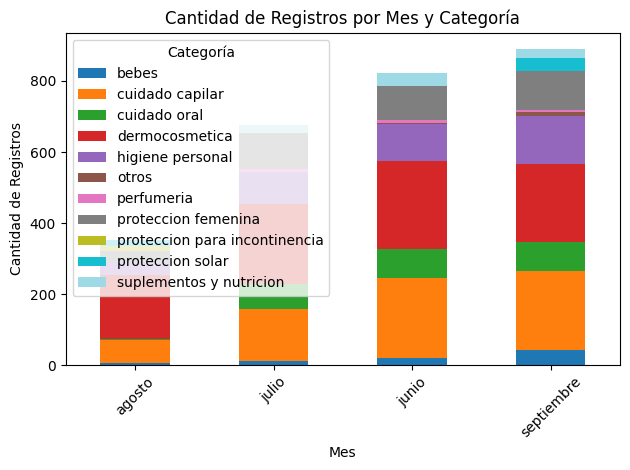

In [69]:
# Contar la cantidad de registros por mes y categoría
contar_por_mes_categoria = df.groupby(['Mes', 'Categoria']).size().unstack(fill_value=0)

# Crear un gráfico de barras apiladas para visualizar la cantidad de registros por mes y categoría
plt.figure(figsize=(14, 7))
contar_por_mes_categoria.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Cantidad de Registros por Mes y Categoría')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

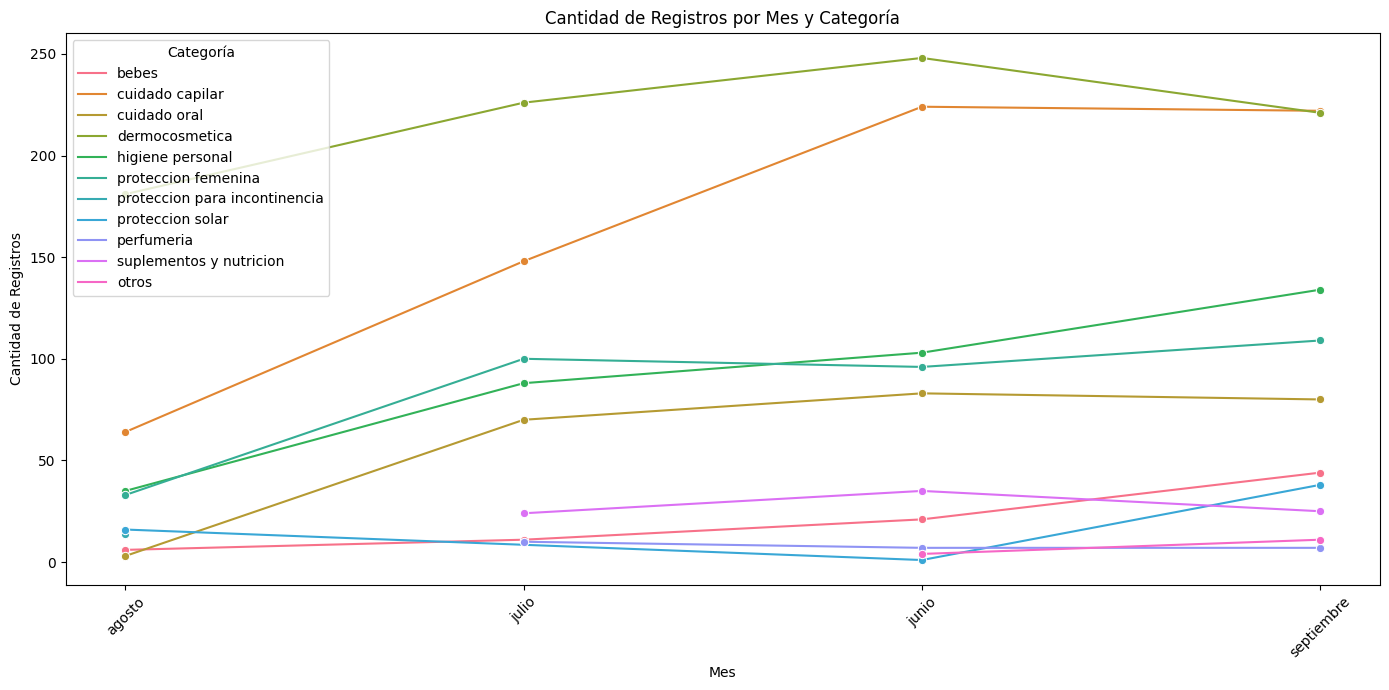

In [70]:
# Contar la cantidad de registros por mes y categoría
contar_por_mes_categoria = df.groupby(['Mes', 'Categoria']).size().reset_index(name='Cantidad')

# Crear un gráfico de líneas para visualizar la cantidad de registros por mes y categoría
plt.figure(figsize=(14, 7))
sns.lineplot(data=contar_por_mes_categoria, x='Mes', y='Cantidad', hue='Categoria', marker='o')
plt.title('Cantidad de Registros por Mes y Categoría')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

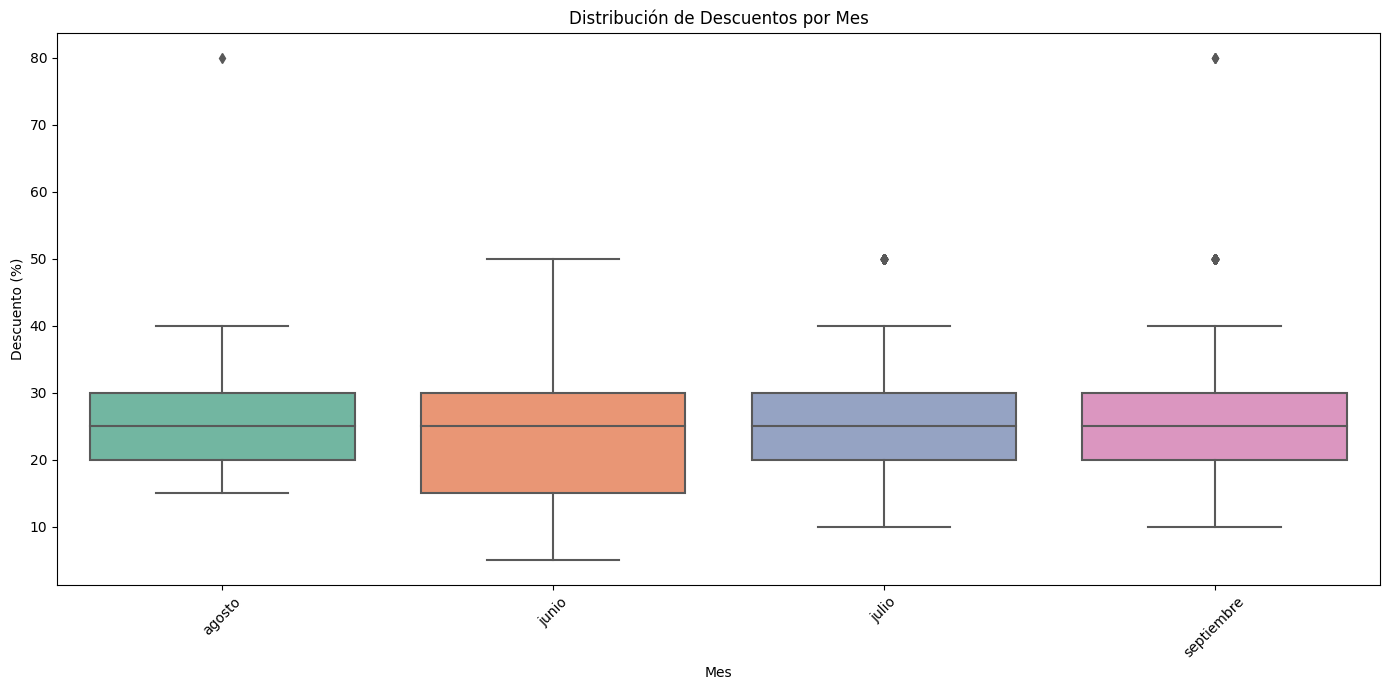

In [72]:
# Asegúrate de que la columna de descuentos esté en formato numérico

# Crear un gráfico de cajas para visualizar la distribución de descuentos por mes
plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Mes', y='Descuento', palette='Set2')
plt.title('Distribución de Descuentos por Mes')
plt.xlabel('Mes')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

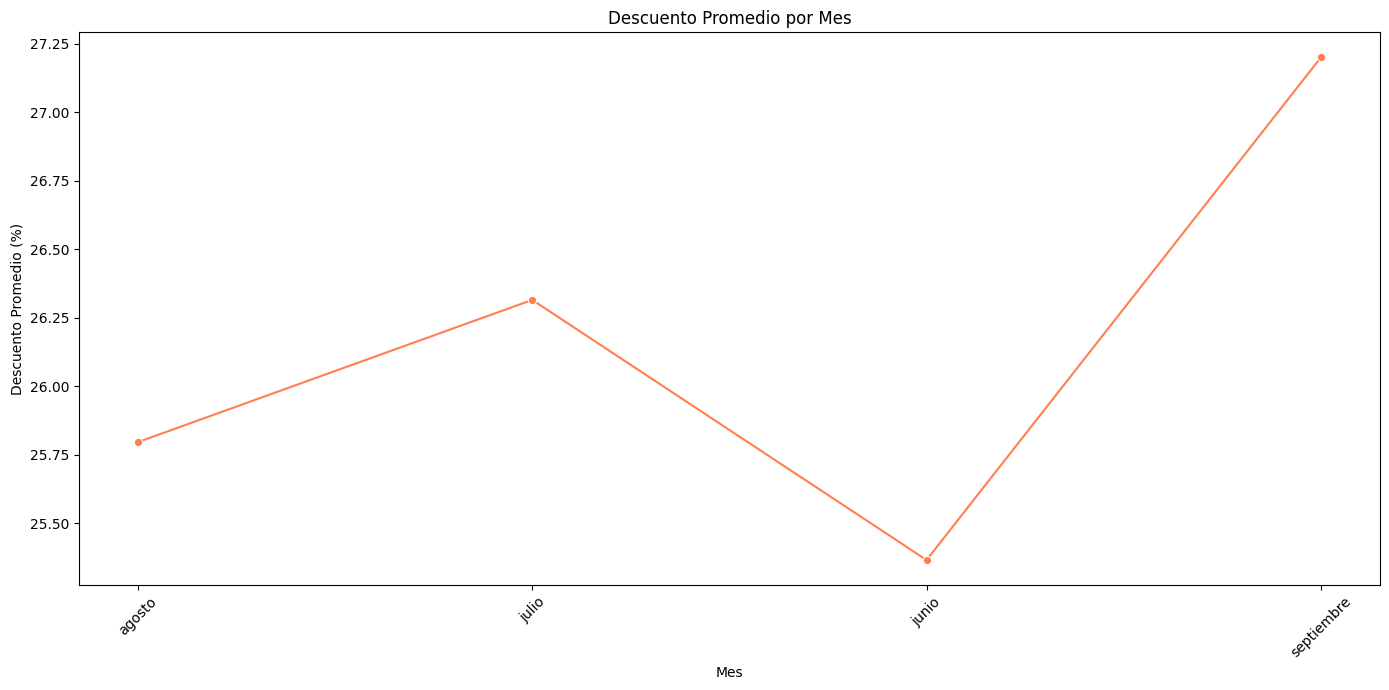

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna a tipo string si no lo es
df['Descuento'] = df['Descuento'].astype(str)

# Limpiar la columna de descuentos (eliminar caracteres no deseados)
df['Descuento'] = df['Descuento'].str.replace('%', '', regex=False)  # Elimina el símbolo de porcentaje
df['Descuento'] = df['Descuento'].replace('', '0')  # Reemplaza valores vacíos por 0
df['Descuento'] = pd.to_numeric(df['Descuento'], errors='coerce')  # Convierte a numérico, convierte errores a NaN

# Calcular el descuento promedio por mes
descuento_promedio_por_mes = df.groupby('Mes')['Descuento'].mean().reset_index()

# Crear un gráfico de líneas para visualizar el descuento promedio por mes
plt.figure(figsize=(14, 7))
sns.lineplot(data=descuento_promedio_por_mes, x='Mes', y='Descuento', marker='o', color='coral')
plt.title('Descuento Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Descuento Promedio (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

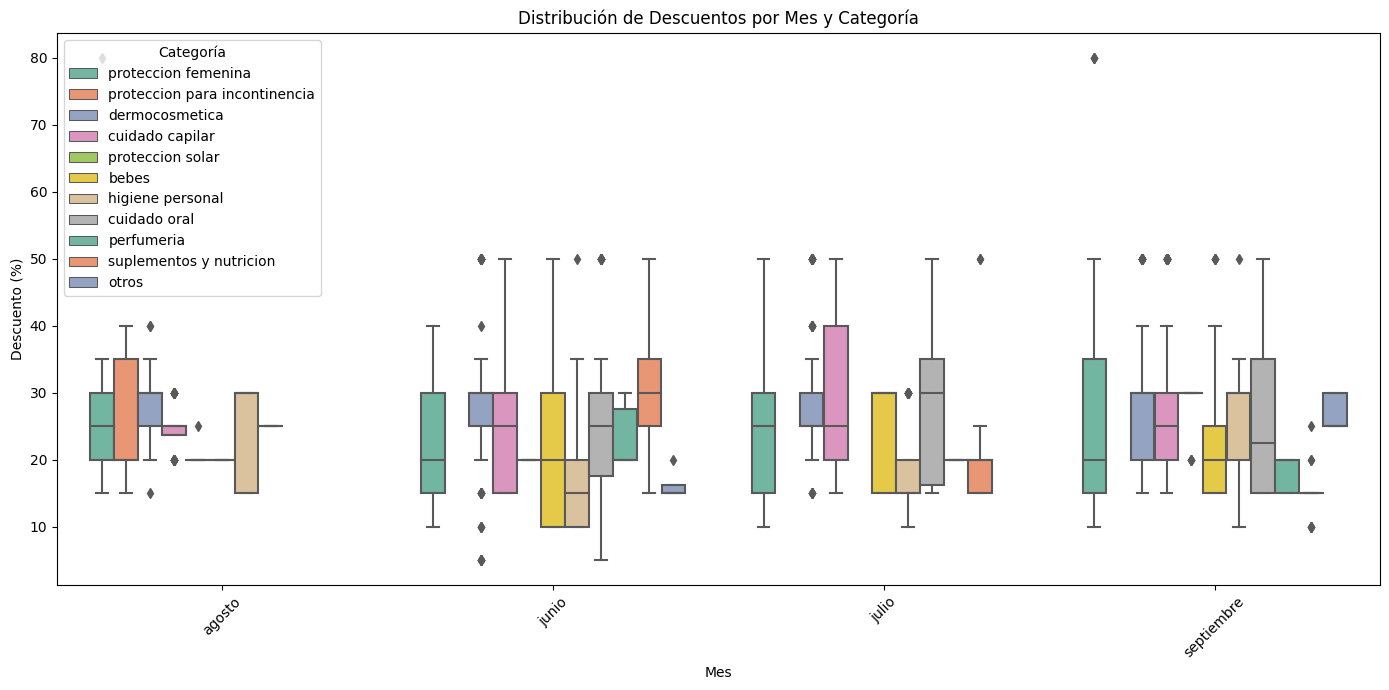

In [74]:
# Convertir descuentos a tipo numérico

plt.figure(figsize=(14, 7))
sns.boxplot(data=df, x='Mes', y='Descuento', hue='Categoria', palette='Set2')
plt.title('Distribución de Descuentos por Mes y Categoría')
plt.xlabel('Mes')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

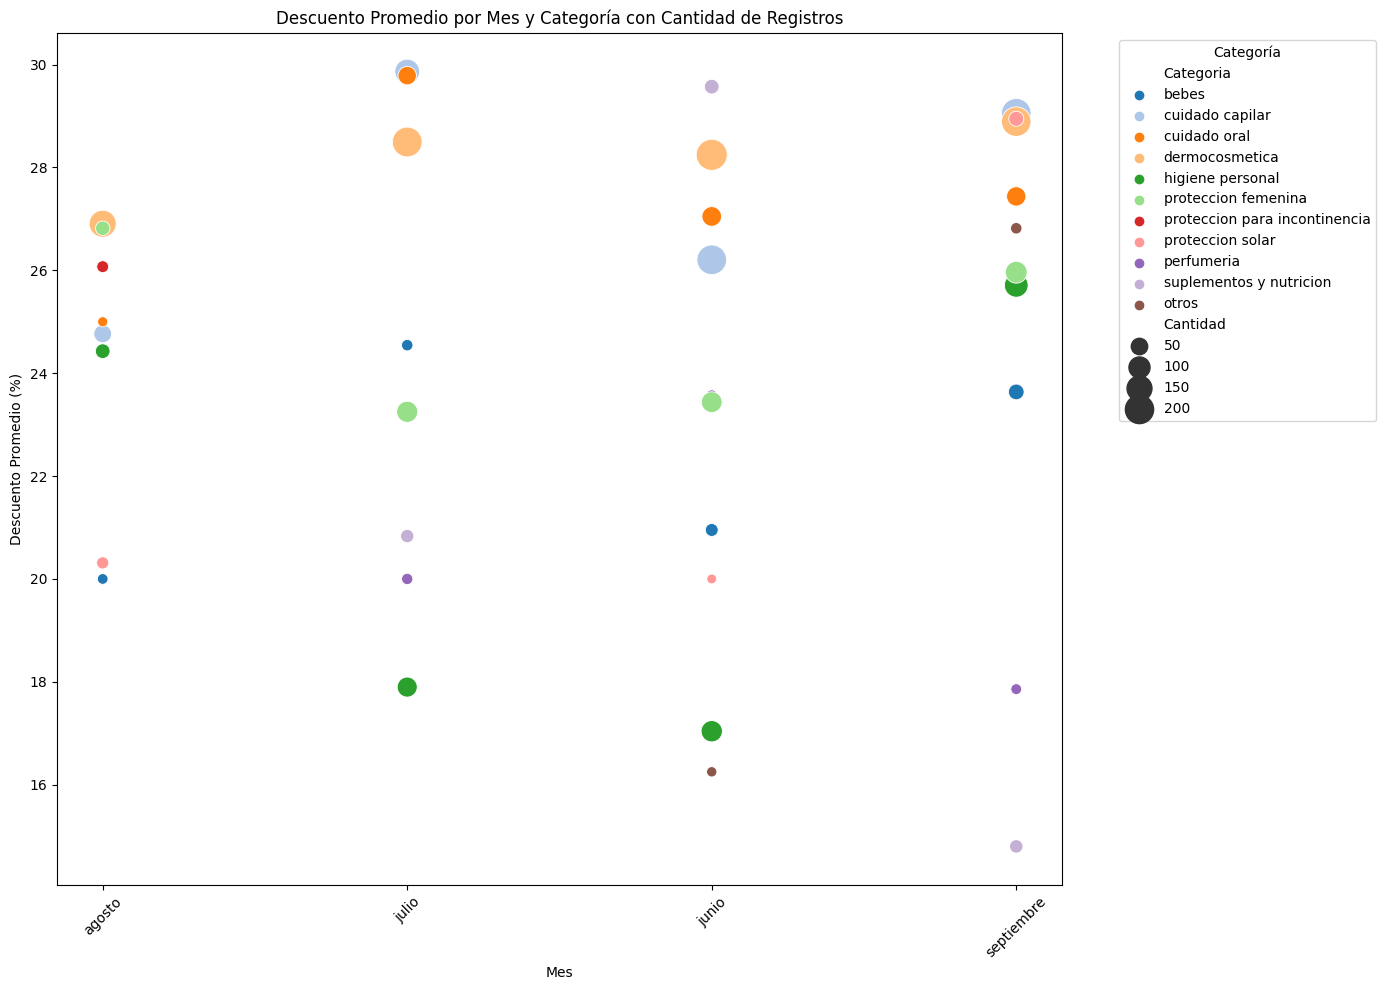

In [75]:
# Calcular el descuento promedio por mes y categoría
descuento_promedio_por_mes_categoria = df.groupby(['Mes', 'Categoria']).agg({'Descuento': 'mean', 'EAN NUEVO': 'size'}).reset_index()
descuento_promedio_por_mes_categoria.rename(columns={'EAN NUEVO': 'Cantidad'}, inplace=True)

# Crear un gráfico de burbujas
plt.figure(figsize=(14, 10))
sns.scatterplot(data=descuento_promedio_por_mes_categoria, x='Mes', y='Descuento', size='Cantidad', hue='Categoria', palette='tab20', sizes=(50, 500))
plt.title('Descuento Promedio por Mes y Categoría con Cantidad de Registros')
plt.xlabel('Mes')
plt.ylabel('Descuento Promedio (%)')
plt.xticks(rotation=45)
plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

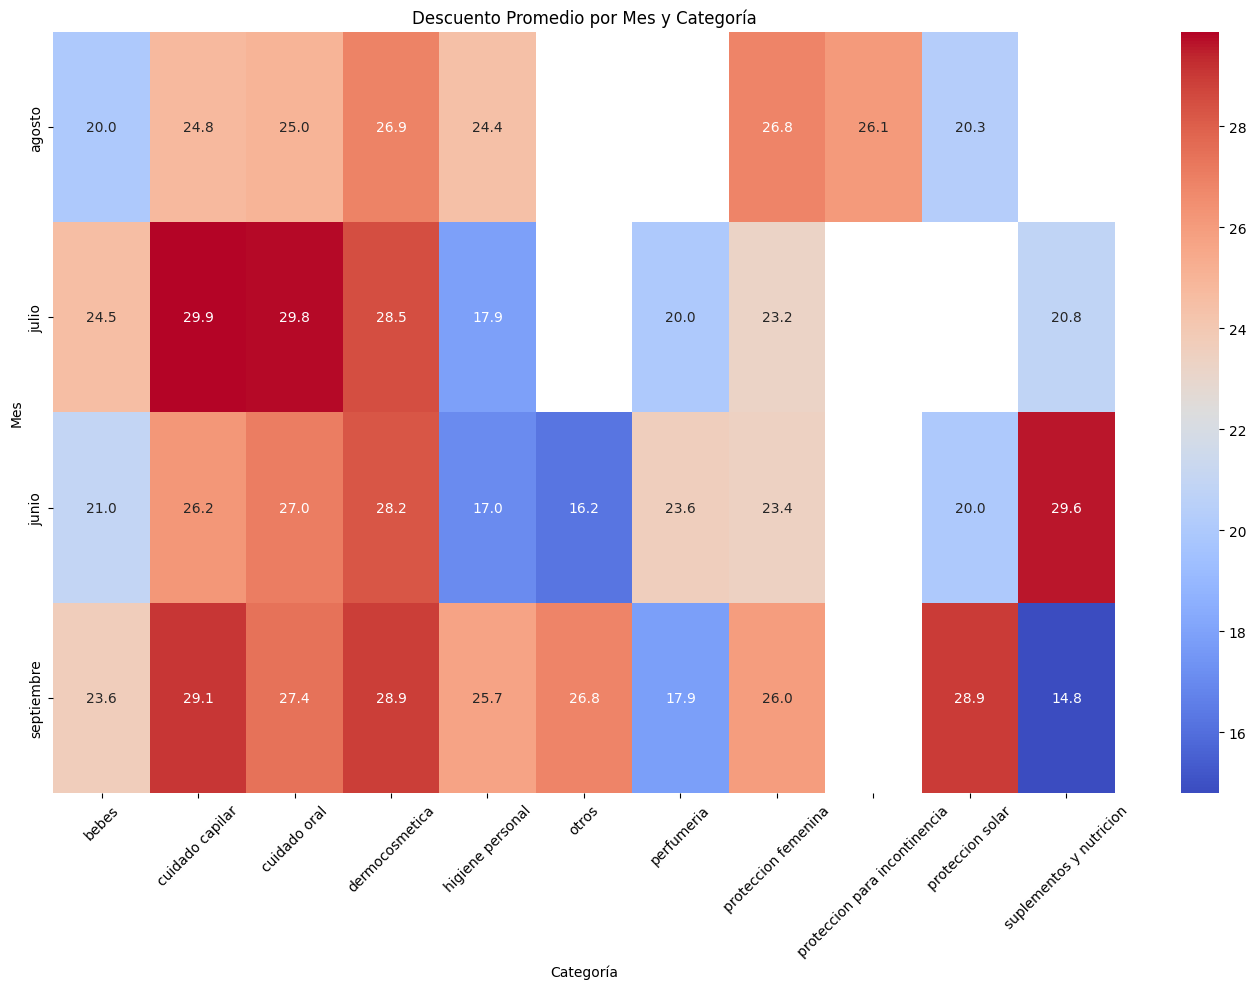

In [76]:
# Calcular la media de descuentos por mes y categoría
descuento_promedio_por_mes_categoria = df.pivot_table(index='Mes', columns='Categoria', values='Descuento', aggfunc='mean')

# Crear un gráfico de calor
plt.figure(figsize=(14, 10))
sns.heatmap(descuento_promedio_por_mes_categoria, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Descuento Promedio por Mes y Categoría')
plt.xlabel('Categoría')
plt.ylabel('Mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [77]:
marcas = {
    'nos': 'Nosotras',
    'veet': 'Veet',
    'ky': 'KY',
    'derma': 'Dermaglós',
    'hs': 'Head & Shoulders',
    'nivea': 'Nivea',
    'pnt': 'Pantene',
    'ptn': 'Pantene',
    'john': 'Johnson',
    'pantene': 'Pantene',
    'venus': 'Venus',
    'pb3': 'Gilette',
    'mach': 'Gilette',
    'm3': 'Gilette',
    'gil': 'Gilette',
    'always': 'Always',
    'aveno': 'Aveno',
    'atrix': 'Atrix',
    'babelito': 'Babelito',
    'bagovit': 'Bagovit',
    'bucal': 'Bucaltac',
    'bushi': 'Bushi',
    'listerine': 'Listerine',
    'hipoglos': 'Hipoglos',
    'neu': 'Neutrogena',
    'tena': 'Tena',
    'calipso': 'Calipso',
    'colgate': 'Colgate',
    'pampers': 'Pampers',
    'espadol': 'Espadol',
    'sensodyne': 'Sensodyne',
    'oral': 'Oral-B',
    'otowil': 'Otowil',
    'kotex': 'Kotex',
    'huggies': 'Huggies',
    'oreal': 'Loreal',
    'siempre': 'Siempre Libre',
    'fructis': 'Fructis',
    'elv': 'Loreal',
    'dove': 'Dove',
    'axe': 'Axe',
    'rexona': 'Rexona',
    'lux': 'Lux',
    'cicatricure': 'Cicatricure',
    'protex': 'Protex',
    'roby': 'Roby',
    'adermicina': 'Adermicina',
    'caladryl': 'Caladryl',
    'evagina': 'Evagina',
    'ena': 'Enaccion',
    'truemade': 'True Made',
    'lomecan': 'Lomecan'

}


In [79]:
# Función para buscar la marca en la descripción
def extraer_marca(descripcion):
    patron = r'(' + '|'.join(marcas.keys()) + r')'
    match = re.search(patron, descripcion, re.IGNORECASE)
    if match:
        alias = match.group(1).lower()  
        return marcas[alias]  
    return None  

# Asegúrate de que todos los valores en la columna 'DESCRIPCIÓN' sean cadenas
df['DESCRIPCIÓN'] = df['DESCRIPCIÓN'].astype(str)

# Aplica la función a la columna 'DESCRIPCIÓN'
df['Marca'] = df['DESCRIPCIÓN'].apply(extraer_marca)

# Imprime los resultados para verificar
print(df[['DESCRIPCIÓN', 'Marca']])

                                     DESCRIPCIÓN     Marca
0       TOAL. NOSOTRAS CLASICA CUR V C/CALE 30X8  Nosotras
1     TOALLA NOSOTRAS CLASICA CUR V C/CALE 15X16  Nosotras
2     TOALLA NOSOTRAS INVISIBLE CUR V C/CALE30X8  Nosotras
3       TOALLA ULTRA INV RAPISEC CUR V 15X14 ARG      None
4            TOAL. NOSOTRAS BN TELA CURVMAX 24X8  Nosotras
...                                          ...       ...
2737                 Acondicionador Aloe Vera v2      None
2738     Acondicionador Crecimiento Saludable v2      None
2739             Acondicionador Celulas Madre v2      None
2740                    Shampoo Celulas Madre v2      None
2741      Crema para peinar reparadora Aloe Vera      None

[2742 rows x 2 columns]


In [80]:
# Para ver las marcas que faltan:
sin_marca = df[df['Marca'].isnull()]

for index, row in sin_marca.iterrows():
    print(f"Descripción: {row['DESCRIPCIÓN']}, Marca: {row['Marca']}")

Descripción: TOALLA ULTRA INV RAPISEC CUR V 15X14 ARG, Marca: None
Descripción: TAMPON DIGITAL REGULAR 12X8 SEDA ARG, Marca: None
Descripción: Q10 Serum Doble Acción Anti Edad, Marca: None
Descripción: BAG. ABSORCION 1 MIN SPY CONT. X 170 ML, Marca: None
Descripción: BAG.BRONC.PROGR.SPRAY CONT. X 150 ML, Marca: None
Descripción: PRURISEDAN CREMA x 30 GR, Marca: None
Descripción: PRURISEDAN LOCIÓN INCOLORA X 60 ML, Marca: None
Descripción: PRURISEDAN POLVO 60 GRS, Marca: None
Descripción: BSC 1181 PINZA DEPILAR LUJO DOBLE MATE ENV x 1, Marca: None
Descripción: BSC 1509 PINZA DEPILAR C/REMOVEDOR PUNTOS NEGROS ENV x 1, Marca: None
Descripción: BSC 2170 GUANTE EXFOLIANTES P/CUERPO BLANCO ENV x 1, Marca: None
Descripción: BSC 5022 SIGNATURE BROCHA MAQUILLAJE ENV x 1, Marca: None
Descripción: BSC 1028 ALICATE P/UÑAS INCLINADO CUCHILLA CURVA ENV x 1, Marca: None
Descripción: Gel Fijación Fuerte Ortiga Concentrado x 160 g, Marca: None
Descripción: Shampoo Ortiga-Caspa Concentrado, Marca: None


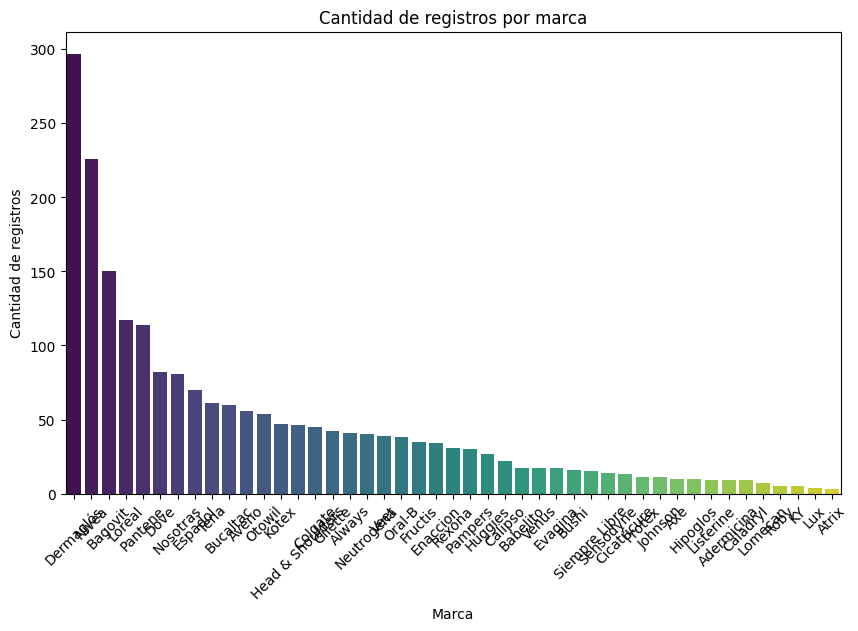

In [81]:
conteo_marcas = df['Marca'].value_counts()
# Gráfico de barras con Seaborn
plt.figure(figsize=(10,6))
sns.barplot(x=conteo_marcas.index, y=conteo_marcas.values, palette='viridis')
plt.title('Cantidad de registros por marca')
plt.xlabel('Marca')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=45)
plt.show()

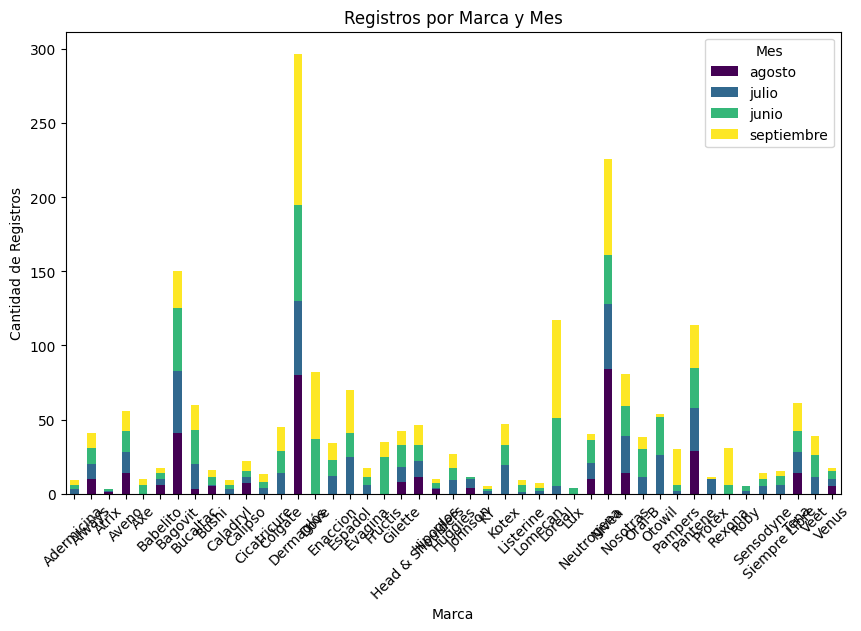

In [82]:
# Agrupar los datos por 'marca' y 'mes' y contar los registros
conteo = df.groupby(['Marca', 'Mes']).size().unstack(fill_value=0)

# Gráfico de barras apiladas
conteo.plot(kind='bar', stacked=True, figsize=(10,6), colormap='viridis')

# Configurar títulos y etiquetas
plt.title('Registros por Marca y Mes')
plt.xlabel('Marca')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=45)
plt.legend(title='Mes')
plt.show()

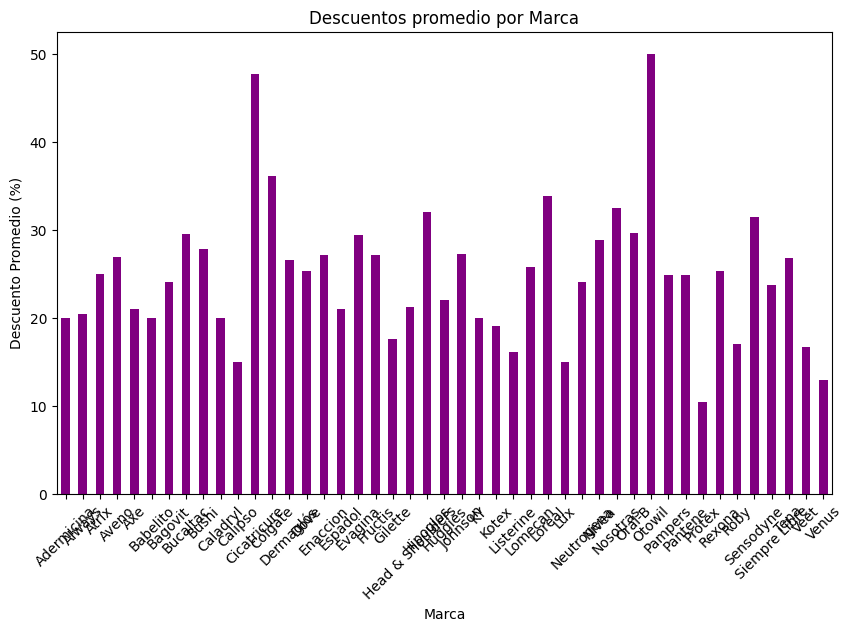

In [84]:
import matplotlib.pyplot as plt

# Agrupar por marca y calcular el promedio de descuentos
descuentos_marca = df.groupby('Marca')['Descuento'].mean()

# Crear el gráfico de barras
descuentos_marca.plot(kind='bar', figsize=(10,6), color='purple')

# Configurar títulos y etiquetas
plt.title('Descuentos promedio por Marca')
plt.xlabel('Marca')
plt.ylabel('Descuento Promedio (%)')
plt.xticks(rotation=45)
plt.show()

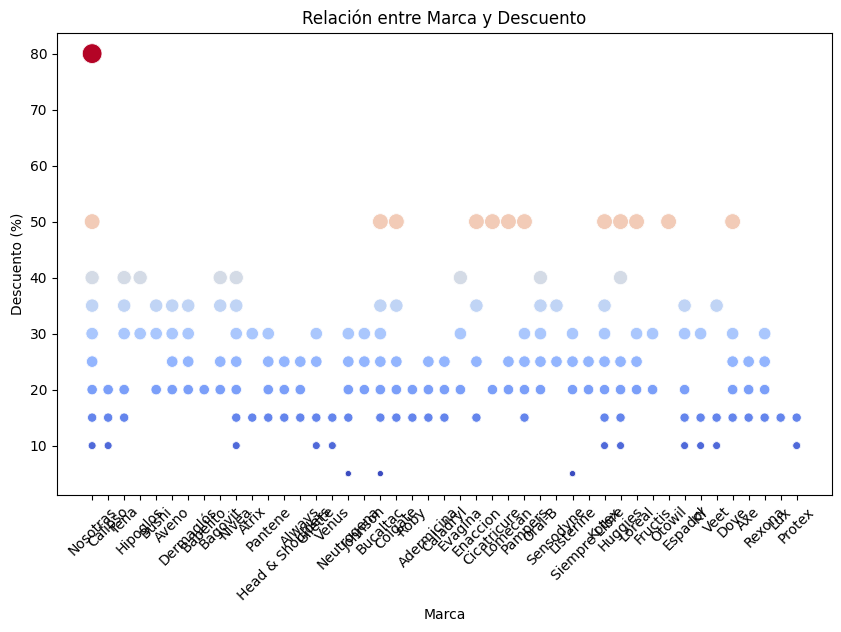

In [85]:
import seaborn as sns

# Crear el gráfico de burbujas (scatter plot)
plt.figure(figsize=(10,6))
sns.scatterplot(x='Marca', y='Descuento', size='Descuento', data=df, sizes=(20, 200), hue='Descuento', palette='coolwarm', legend=False)

# Configurar títulos y etiquetas
plt.title('Relación entre Marca y Descuento')
plt.xlabel('Marca')
plt.ylabel('Descuento (%)')
plt.xticks(rotation=45)
plt.show()